In [14]:
# =========================================
# Fashion-MNIST GAN with Model Save/Load
# =========================================

import os
import sys
import subprocess
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import imageio
from glob import glob

# Suppress TensorFlow optimizer logs
tf.get_logger().setLevel("ERROR")
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  # suppress remapper warnings

# ------------------------------
# 1. Setup directories
# ------------------------------
OUTPUT_DIR = "gan_outputs"
GENERATOR_PATH = os.path.join(OUTPUT_DIR, "generator_fashion_mnist.h5")
DISCRIMINATOR_PATH = os.path.join(OUTPUT_DIR, "discriminator_fashion_mnist.h5")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------
# 2. Load & preprocess Fashion-MNIST
# ------------------------------
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5  # normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# ------------------------------
# 3. Generator
# ------------------------------
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7,7,256)))
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",use_bias=False,activation="tanh"))
    return model

# ------------------------------
# 4. Discriminator
# ------------------------------
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# ------------------------------
# 5. Loss & Optimizers
# ------------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ------------------------------
# 6. Load models if exist
# ------------------------------
if os.path.exists(GENERATOR_PATH) and os.path.exists(DISCRIMINATOR_PATH):
    generator = load_model(GENERATOR_PATH)
    discriminator = load_model(DISCRIMINATOR_PATH)
    print(" Loaded existing Generator and Discriminator models.")
else:
    generator = make_generator_model()
    discriminator = make_discriminator_model()
    print(" No saved models found. New models created.")

# ------------------------------
# 7. Training
# ------------------------------
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i,:,:,0]+1)/2.0, cmap="gray")
        plt.axis("off")
    filename = os.path.join(OUTPUT_DIR,f"epoch_{epoch:03d}.png")
    plt.savefig(filename)
    plt.close()

def train(dataset, epochs):
    for epoch in range(1, epochs+1):
        for image_batch in dataset:
            train_step(image_batch)

        if epoch % 1 == 0:
            generate_and_save_images(generator, epoch, seed)

        print(f" Epoch {epoch}/{epochs} completed.")

    # Save models
    generator.save(GENERATOR_PATH)
    discriminator.save(DISCRIMINATOR_PATH)
    print(f" Generator and Discriminator saved at {OUTPUT_DIR}.")

# ------------------------------
# 8. Create GIF
# ------------------------------
def create_gif(output_dir="gan_outputs", gif_name="training_progress.gif"):
    frames = []
    files = sorted(glob(os.path.join(output_dir,"epoch_*.png")))
    for file in files:
        frames.append(imageio.imread(file))

    gif_path = os.path.join(output_dir, gif_name)

    if frames:
        imageio.mimsave(gif_path, frames, fps=5)
        print(f" GIF saved at {gif_path}")
        try:
            if sys.platform.startswith("darwin"):
                subprocess.call(["open", gif_path])
            elif os.name=="nt":
                os.startfile(gif_path)
            elif os.name=="posix":
                subprocess.call(["xdg-open", gif_path])
        except:
            pass
    else:
        print("⚠️ No images found to make GIF.")

# ------------------------------
# 9. Optional inference
# ------------------------------
def generate_images(n=16):
    noise = tf.random.normal([n, noise_dim])
    images = generator(noise, training=False)
    for i in range(n):
        img = (images[i]+1)/2.0
        plt.imshow(img[:,:,0], cmap="gray")
        plt.axis("off")
        plt.show()

# ------------------------------
# 10. Run script
# ------------------------------
if __name__=="__main__":
    # Train only if models do not exist
    if not (os.path.exists(GENERATOR_PATH) and os.path.exists(DISCRIMINATOR_PATH)):
        train(dataset, EPOCHS)
    else:
        print(" Models already exist. Skipping training.")

    create_gif(OUTPUT_DIR)
    # Optional: generate a few images
    # generate_images(5)


 Loaded existing Generator and Discriminator models.
 Models already exist. Skipping training.
 GIF saved at gan_outputs/training_progress.gif


/tmp/ipython-input-568028258.py:157: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(file))


✅ Synthetic dataset created: (200, 32, 32, 3)
✅ Loaded existing models.
 Epoch 1/100 completed.
 Epoch 2/100 completed.
 Epoch 3/100 completed.
 Epoch 4/100 completed.
 Epoch 5/100 completed.
 Epoch 6/100 completed.
 Epoch 7/100 completed.
 Epoch 8/100 completed.
 Epoch 9/100 completed.
 Epoch 10/100 completed.
 Epoch 11/100 completed.
 Epoch 12/100 completed.
 Epoch 13/100 completed.
 Epoch 14/100 completed.
 Epoch 15/100 completed.
 Epoch 16/100 completed.
 Epoch 17/100 completed.
 Epoch 18/100 completed.
 Epoch 19/100 completed.
 Epoch 20/100 completed.
 Epoch 21/100 completed.
 Epoch 22/100 completed.
 Epoch 23/100 completed.
 Epoch 24/100 completed.
 Epoch 25/100 completed.
 Epoch 26/100 completed.
 Epoch 27/100 completed.
 Epoch 28/100 completed.
 Epoch 29/100 completed.
 Epoch 30/100 completed.
 Epoch 31/100 completed.
 Epoch 32/100 completed.
 Epoch 33/100 completed.
 Epoch 34/100 completed.
 Epoch 35/100 completed.
 Epoch 36/100 completed.
 Epoch 37/100 completed.
 Epoch 38/10

/tmp/ipython-input-2101611526.py:213: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f))


🎞️ GIF saved at rgb_gan_outputs/training.gif


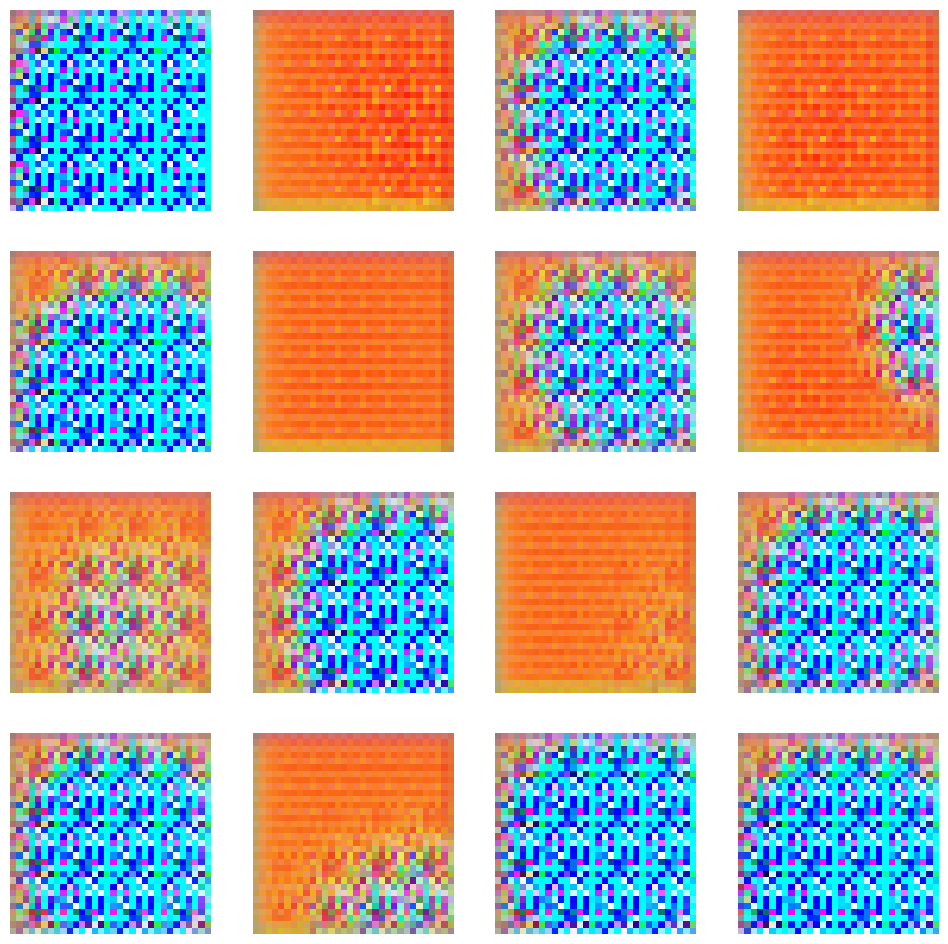

In [22]:
# =========================================
# RGB Fabric GAN - Synthetic Data Training
# =========================================

import os
import sys
import subprocess
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
from glob import glob

# Suppress TF warnings
tf.get_logger().setLevel("ERROR")
os.environ["TF_ENABLE_ONEDNN_OPTS"]="0"

# ------------------------------
# 1. Directories & Paths
# ------------------------------
OUTPUT_DIR = "rgb_gan_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
GENERATOR_PATH = os.path.join(OUTPUT_DIR, "generator_rgb.keras")
DISCRIMINATOR_PATH = os.path.join(OUTPUT_DIR, "discriminator_rgb.keras")

# ------------------------------
# 2. Generate synthetic RGB dataset
# ------------------------------
IMG_SIZE = 32
CHANNELS = 3
NUM_PER_PATTERN = 50

def create_synthetic_dataset():
    images = []

    # Stripes
    for _ in range(NUM_PER_PATTERN):
        img = np.zeros((IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.uint8)
        color1 = np.random.randint(50, 255, 3)
        color2 = np.random.randint(50, 255, 3)
        for j in range(IMG_SIZE):
            img[j, :, :] = color1 if j % 8 < 4 else color2
        images.append(img)

    # Checkerboard
    for _ in range(NUM_PER_PATTERN):
        img = np.zeros((IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.uint8)
        color1 = np.random.randint(50, 255, 3)
        color2 = np.random.randint(50, 255, 3)
        for x in range(IMG_SIZE):
            for y in range(IMG_SIZE):
                img[x, y, :] = color1 if (x // 4 + y // 4) % 2 == 0 else color2
        images.append(img)

    # Simple floral dots
    for _ in range(NUM_PER_PATTERN):
        img = np.zeros((IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.uint8)
        bg = np.random.randint(150, 255, 3)
        dot = np.random.randint(0, 150, 3)
        img[:, :, :] = bg
        for _ in range(10):
            cx, cy = np.random.randint(0, IMG_SIZE, 2)
            r = np.random.randint(2, 5)
            # Convert dot color to tuple of ints for OpenCV
            cv2.circle(img, (cx, cy), r, tuple(int(c) for c in dot), -1)
        images.append(img)

    # Geometric patterns
    for _ in range(NUM_PER_PATTERN):
        img = np.zeros((IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.uint8)
        color1 = np.random.randint(50, 255, 3)
        color2 = np.random.randint(50, 255, 3)
        for x in range(IMG_SIZE):
            for y in range(IMG_SIZE):
                img[x, y, :] = color1 if (x * y) % 8 < 4 else color2
        images.append(img)

    images = np.array(images, dtype=np.float32)
    images = (images - 127.5) / 127.5   # normalize [-1,1]
    print(f"✅ Synthetic dataset created: {images.shape}")
    return images

dataset_images = create_synthetic_dataset()
BUFFER_SIZE = dataset_images.shape[0]
BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices(dataset_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# ------------------------------
# 3. Generator
# ------------------------------
LATENT_DIM = 100
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256,use_bias=False,input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4,4,256)))

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32,(5,5),strides=(2,2),padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(CHANNELS,(5,5),strides=(1,1),padding="same",use_bias=False,activation="tanh"))
    return model

# ------------------------------
# 4. Discriminator
# ------------------------------
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[IMG_SIZE,IMG_SIZE,CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# ------------------------------
# 5. Loss & Optimizers
# ------------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real,fake):
    return cross_entropy(tf.ones_like(real),real) + cross_entropy(tf.zeros_like(fake),fake)
def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake),fake)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ------------------------------
# 6. Load or create models
# ------------------------------
if os.path.exists(GENERATOR_PATH) and os.path.exists(DISCRIMINATOR_PATH):
    generator = load_model(GENERATOR_PATH)
    discriminator = load_model(DISCRIMINATOR_PATH)
    print("✅ Loaded existing models.")
else:
    generator = build_generator()
    discriminator = build_discriminator()
    print("⚠️ New models created.")

# ------------------------------
# 7. Training functions
# ------------------------------
EPOCHS = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate,LATENT_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

def generate_and_save_images(model,epoch,test_input):
    predictions = model(test_input,training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        img = (predictions[i]+1)/2.0
        plt.imshow(img)
        plt.axis("off")
    plt.savefig(os.path.join(OUTPUT_DIR,f"epoch_{epoch:03d}.png"))
    plt.close()

def train(dataset,epochs):
    for epoch in range(1,epochs+1):
        for batch in dataset:
            train_step(batch)
        generate_and_save_images(generator,epoch,seed)
        print(f" Epoch {epoch}/{epochs} completed.")

    # Save models in modern Keras format
    generator.save(GENERATOR_PATH)
    discriminator.save(DISCRIMINATOR_PATH)
    print(" Generator and Discriminator saved.")

# ------------------------------
# 8. Create GIF
# ------------------------------
def create_gif(output_dir=OUTPUT_DIR,gif_name="training.gif"):
    frames=[]
    files=sorted(glob(os.path.join(output_dir,"epoch_*.png")))
    for f in files:
        frames.append(imageio.imread(f))
    if frames:
        gif_path=os.path.join(output_dir,gif_name)
        imageio.mimsave(gif_path,frames,fps=5)
        print(f"🎞️ GIF saved at {gif_path}")
        try:
            if sys.platform.startswith("darwin"):
                subprocess.call(["open",gif_path])
            elif os.name=="nt":
                os.startfile(gif_path)
            elif os.name=="posix":
                subprocess.call(["xdg-open",gif_path])
        except: pass

# ------------------------------
# 9. Optional inference
# ------------------------------
def generate_images(n=16):
    noise = tf.random.normal([n,LATENT_DIM])
    images = generator(noise,training=False)
    fig, axes = plt.subplots((n+3)//4,4,figsize=(12,12))
    axes = axes.flatten()
    for i,img in enumerate(images):
        axes[i].imshow((img+1)/2.0)
        axes[i].axis("off")
    plt.show()

# ------------------------------
# 10. Run
# ------------------------------
if __name__=="__main__":
    train(dataset,EPOCHS)
    create_gif()
    generate_images(16)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Epoch 1/100 completed.
✅ Epoch 2/100 completed.
✅ Epoch 3/100 completed.
✅ Epoch 4/100 completed.
✅ Epoch 5/100 completed.
✅ Epoch 6/100 completed.
✅ Epoch 7/100 completed.
✅ Epoch 8/100 completed.
✅ Epoch 9/100 completed.
✅ Epoch 10/100 completed.
✅ Epoch 11/100 completed.
✅ Epoch 12/100 completed.
✅ Epoch 13/100 completed.
✅ Epoch 14/100 completed.
✅ Epoch 15/100 completed.
✅ Epoch 16/100 completed.
✅ Epoch 17/100 completed.
✅ Epoch 18/100 completed.
✅ Epoch 19/100 completed.
✅ Epoch 20/100 completed.
✅ Epoch 21/100 completed.
✅ Epoch 22/100 completed.
✅ Epoch 23/100 completed.
✅ Epoch 24/100 completed.
✅ Epoch 25/100 completed.
✅ Epoch 26/100 completed.
✅ Epoch 27/100 completed.
✅ Epoch 28/100 completed.
✅ Epoch 29/100 completed.
✅ Epoch 30/100 completed.
✅ Epoch 31/100 completed.
✅ Epoch 32/100 completed.
✅ Epoch 33/100 completed.
✅ Epoch 34/100 completed.
✅ Epoch 35/100 completed.
✅ Epoch 36/100 completed.
✅ Epoch 37/100 completed.
✅ Epoch 38/100 completed.
✅ Epoch 39/100 comple

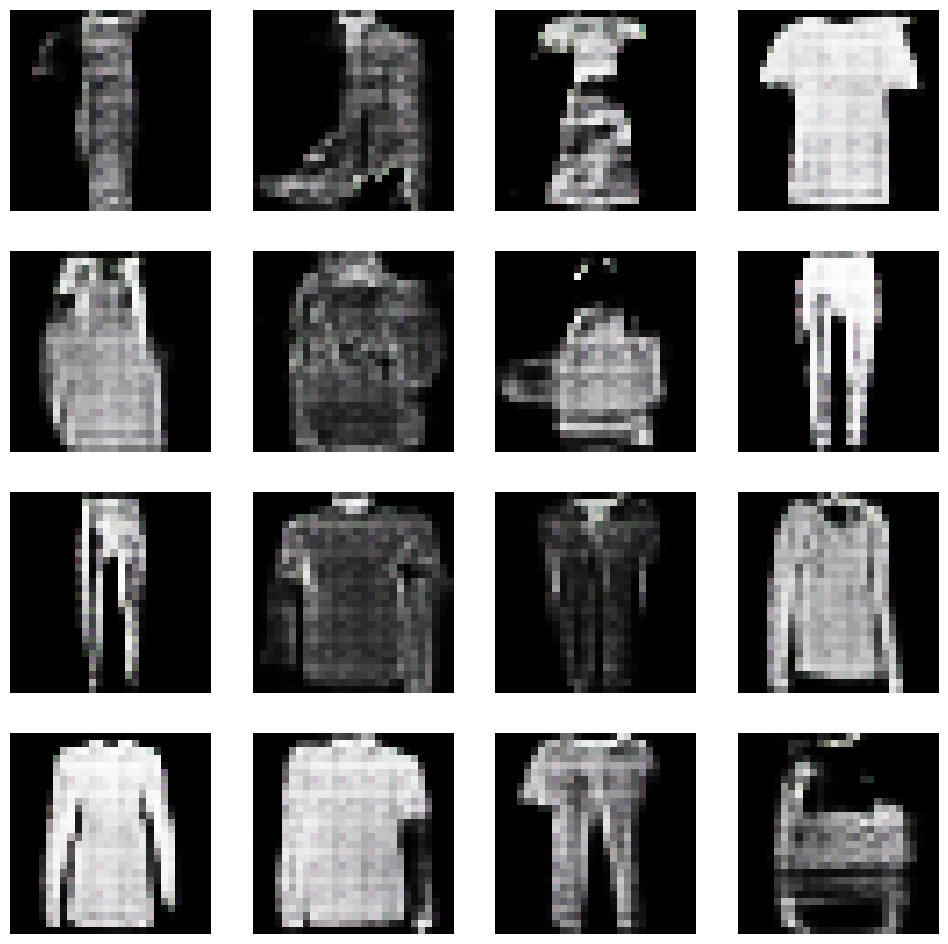

✅ 16 patterns saved in fashion_rgb_gan/generated_patterns/


In [23]:
# =========================================
# RGB Fashion-MNIST GAN
# =========================================

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------
# 1. Directories
# ------------------------------
OUTPUT_DIR = "fashion_rgb_gan"
os.makedirs(OUTPUT_DIR, exist_ok=True)
GENERATOR_PATH = os.path.join(OUTPUT_DIR, "generator_fashion_rgb.keras")
GENERATED_DIR = os.path.join(OUTPUT_DIR, "generated_patterns")
os.makedirs(GENERATED_DIR, exist_ok=True)

# ------------------------------
# 2. Load Fashion-MNIST and preprocess
# ------------------------------
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(-1,28,28,1).astype("float32")
train_images = np.repeat(train_images, 3, axis=-1)  # convert to RGB
train_images = (train_images - 127.5) / 127.5       # [-1,1]

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# ------------------------------
# 3. Generator
# ------------------------------
LATENT_DIM = 100
CHANNELS = 3

def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7,7,256)))

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(CHANNELS,(5,5),strides=(2,2),padding="same",use_bias=False,activation="tanh"))
    return model

# ------------------------------
# 4. Discriminator
# ------------------------------
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[28,28,CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# ------------------------------
# 5. Loss & Optimizers
# ------------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real,fake):
    return cross_entropy(tf.ones_like(real),real)+cross_entropy(tf.zeros_like(fake),fake)
def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake),fake)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ------------------------------
# 6. Training
# ------------------------------
EPOCHS = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate,LATENT_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

def generate_and_save_images(model,epoch,test_input):
    predictions = model(test_input,training=False)
    fig, axes = plt.subplots(4,4,figsize=(8,8))
    axes = axes.flatten()
    for i,img in enumerate(predictions):
        img = (img+1)/2.0
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR,f"epoch_{epoch:03d}.png"))
    plt.close()

def train(dataset,epochs):
    for epoch in range(1,epochs+1):
        for batch in dataset:
            train_step(batch)
        generate_and_save_images(generator,epoch,seed)
        print(f"✅ Epoch {epoch}/{epochs} completed.")
    # Save generator
    generator.save(GENERATOR_PATH)
    print(f"💾 Generator saved at {GENERATOR_PATH}")

# ------------------------------
# 7. Inference
# ------------------------------
def generate_images(n=16):
    noise = tf.random.normal([n,LATENT_DIM])
    images = generator(noise,training=False)
    fig, axes = plt.subplots((n+3)//4,4,figsize=(12,12))
    axes = axes.flatten()
    for i,img in enumerate(images):
        axes[i].imshow((img+1)/2.0)
        axes[i].axis("off")
        # Save each image
        img_uint8 = (img.numpy()*255).astype(np.uint8)
        Image.fromarray(img_uint8).save(os.path.join(GENERATED_DIR,f"pattern_{i+1}.png"))
    plt.show()
    print(f"✅ {n} patterns saved in {GENERATED_DIR}/")

# ------------------------------
# 8. Run
# ------------------------------
if __name__=="__main__":
    train(dataset,EPOCHS)
    generate_images(16)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.35MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.8MB/s]


Shape of X [N C H W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cuda device
NeuralNetwork(
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.300215  [    0/60000]
loss: 2.175742  [ 6400/60000]
loss: 1.851119  [12800/60000]
loss: 1.547684  [19200/60000]
loss: 1.166898  [25600/60000]
loss: 1.063617  [32000/60000]
loss: 1.003633  [38400/60000]
loss: 0.887456  [44800/60000]
loss: 0.859702  [51200/60000]
loss: 0.800775  [57600/60000]
Test Error: 
 Accuracy: 70.9%, Avg loss: 0.792318 

Epoch 2
-------------------------------
loss: 0.778904  [    0/60000]
loss: 0.833086  [ 6400/60000]
loss: 0.580272  [12800/60000]
loss: 0.813087  [19200/60000]
loss: 0.679118  [256

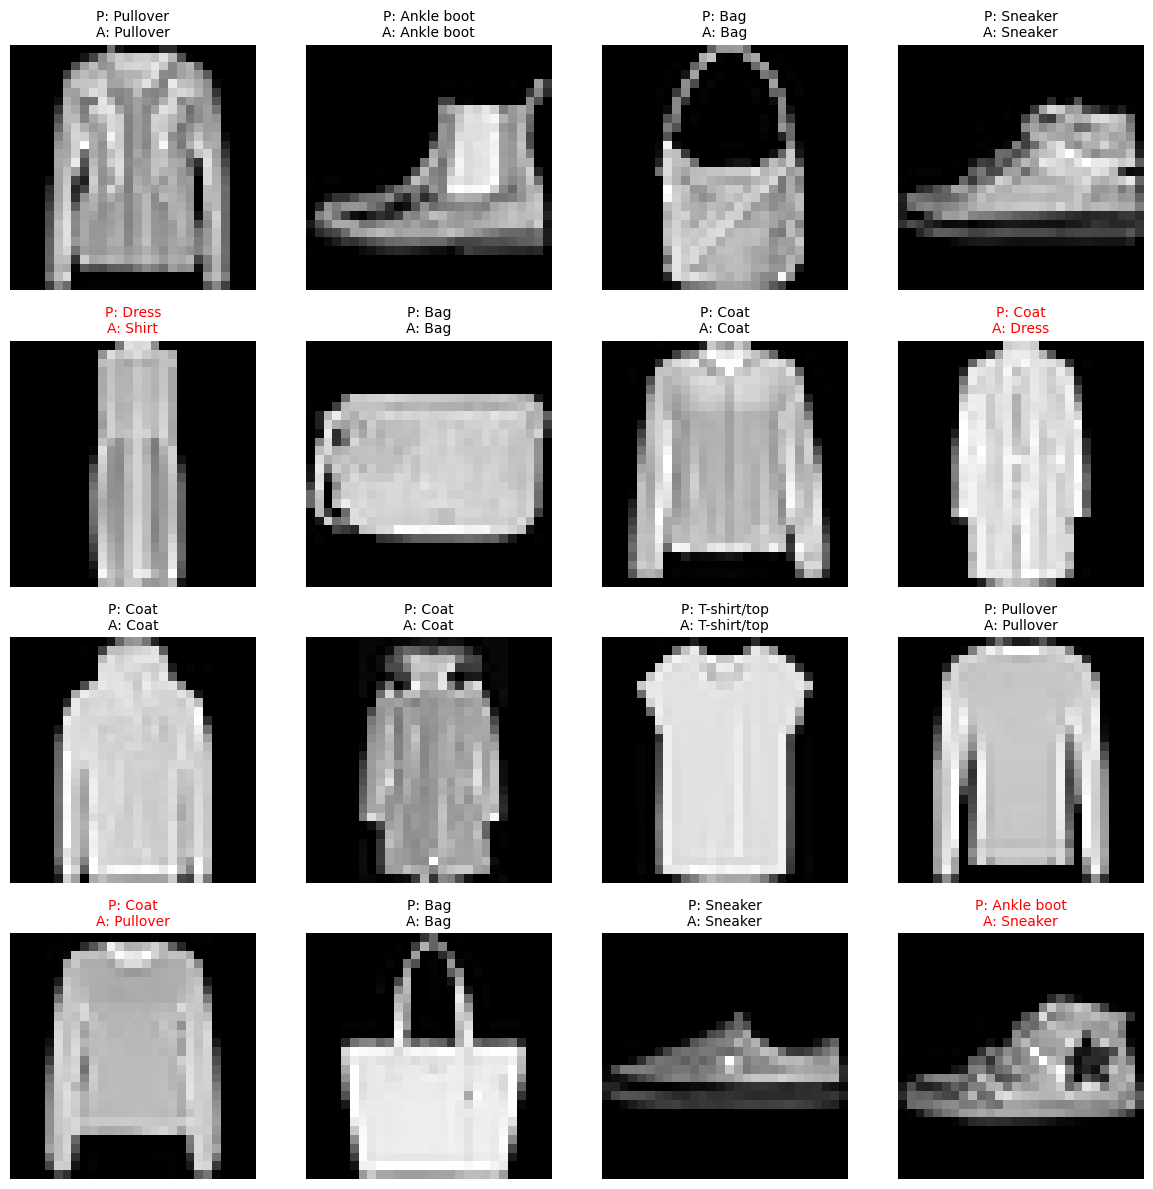

In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random

# -----------------------
# Load the FashionMNIST dataset
# -----------------------
training_data = datasets.FashionMNIST(
    train=True,
    transform=ToTensor(),
    download=True,
    root="data"
)

test_data = datasets.FashionMNIST(
    train=False,
    transform=ToTensor(),
    download=True,
    root="data"
)

batch_size = 64
training_loader = DataLoader(training_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# -----------------------
# Check a sample
# -----------------------
for X, y in test_loader:
    print(f"Shape of X [N C H W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# -----------------------
# Device configuration
# -----------------------
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(f"Using {device} device")

# -----------------------
# Define the Neural Network
# -----------------------
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.Flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.Flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

# -----------------------
# Loss function and optimizer
# -----------------------
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# -----------------------
# Training function
# -----------------------
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        prediction = model(X)
        loss = loss_fn(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

# -----------------------
# Testing function
# -----------------------
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            prediction = model(X)
            test_loss += loss_fn(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# -----------------------
# Train the model
# -----------------------
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

# -----------------------
# Save the model
# -----------------------
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# -----------------------
# Load the model
# -----------------------
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

# -----------------------
# Class labels
# -----------------------
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# -----------------------
# Display multiple predictions
# -----------------------
model.eval()
num_images = 16
rows, cols = 4, 4
sample_indices = random.sample(range(len(test_data)), num_images)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(sample_indices):
    x, y = test_data[idx][0], test_data[idx][1]

    with torch.no_grad():
        x_device = x.to(device)
        prediction = model(x_device.unsqueeze(0))
        predicted_class = classes[prediction.argmax(dim=1).item()]
        actual_class = classes[y]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(x.squeeze(), cmap="gray")
    # Highlight wrong predictions in red
    color = "red" if predicted_class != actual_class else "black"
    plt.title(f"P: {predicted_class}\nA: {actual_class}", color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [28]:
# ==============================
# Fashion-MNIST GAN Training Script (with Model Save/Load)
# ==============================

import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # suppress remapper warnings

import sys
import subprocess
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import imageio
from glob import glob

# Suppress TensorFlow optimizer logs
tf.get_logger().setLevel("ERROR")

# ------------------------------
# 1. Setup output directory
# ------------------------------
OUTPUT_DIR = "gan_outputs"
MODEL_PATH = os.path.join(OUTPUT_DIR, "generator_fashion_mnist.h5")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------
# 2. Load & preprocess Fashion-MNIST
# ------------------------------
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5  # normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# ------------------------------
# 3. Generator
# ------------------------------
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))

    return model

# ------------------------------
# 4. Discriminator
# ------------------------------
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# ------------------------------
# 5. Loss & Optimizers
# ------------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ------------------------------
# 6. Training loop
# ------------------------------
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap="gray")
        plt.axis("off")

    filename = os.path.join(OUTPUT_DIR, f"epoch_{epoch:03d}.png")
    plt.savefig(filename)
    plt.close()

def train(dataset, epochs):
    for epoch in range(1, epochs+1):
        for image_batch in dataset:
            train_step(image_batch)

        # Save images every 5 epochs, plus first and last
        if epoch % 5 == 0 or epoch == 1 or epoch == epochs:
            generate_and_save_images(generator, epoch, seed)

        print(f"✅ Epoch {epoch}/{epochs} completed.")

    # Save trained generator at the end
    generator.save(MODEL_PATH)
    print(f"💾 Trained generator saved at {MODEL_PATH}")

# ------------------------------
# 7. GIF Maker (auto-open)
# ------------------------------
def create_gif(output_dir="gan_outputs", gif_name="training_progress.gif"):
    frames = []
    files = sorted(glob(os.path.join(output_dir, "epoch_*.png")))
    for file in files:
        frames.append(imageio.imread(file))

    gif_path = os.path.join(output_dir, gif_name)

    if frames:
        imageio.mimsave(gif_path, frames, fps=5)
        print(f"🎞️ GIF saved at {gif_path}")

        # Auto-open depending on OS
        try:
            if sys.platform.startswith("darwin"):   # macOS
                subprocess.call(["open", gif_path])
            elif os.name == "nt":                   # Windows
                os.startfile(gif_path)
            elif os.name == "posix":                # Linux
                subprocess.call(["xdg-open", gif_path])
        except Exception as e:
            print(f"⚠️ Could not auto-open GIF: {e}")

    else:
        print("⚠️ No images found to make GIF.")

# ------------------------------
# 8. Run Training
# ------------------------------
if __name__ == "__main__":
    train(dataset, EPOCHS)
    create_gif(OUTPUT_DIR)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Epoch 1/5 completed.
✅ Epoch 2/5 completed.
✅ Epoch 3/5 completed.
✅ Epoch 4/5 completed.


✅ Epoch 5/5 completed.
💾 Trained generator saved at gan_outputs/generator_fashion_mnist.h5
🎞️ GIF saved at gan_outputs/training_progress.gif


/tmp/ipython-input-2788540910.py:161: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(file))


In [34]:
# gan_fashion_mnist.py
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# -----------------------
# Device
# -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -----------------------
# Hyperparameters
# -----------------------
batch_size = 128
epochs = 5
noise_dim = 100
num_gen_images = 1000  # Number of images to generate
output_dir = "gan_images"
os.makedirs(output_dir, exist_ok=True)

# -----------------------
# Dataset
# -----------------------
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# -----------------------
# GAN Models
# -----------------------
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256*7*7),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1,(256,7,7)),
            nn.ConvTranspose2d(256,128,5,stride=1,padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128,64,5,stride=2,padding=2,output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64,1,5,stride=2,padding=2,output_padding=1),
            nn.Tanh()
        )
    def forward(self,x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1,64,5,2,2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64,128,5,2,2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*7*7,1)
        )
    def forward(self,x):
        return self.model(x)

# -----------------------
# Loss & Optimizers
# -----------------------
adversarial_loss = nn.BCEWithLogitsLoss()
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# -----------------------
# Train GAN
# -----------------------
for epoch in range(epochs):
    for real_imgs,_ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size_curr = real_imgs.size(0)
        valid = torch.ones(batch_size_curr,1,device=device)
        fake = torch.zeros(batch_size_curr,1,device=device)

        # Train generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr, noise_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss)/2
        d_loss.backward()
        optimizer_D.step()

    print(f"[GAN] Epoch {epoch+1}/{epochs} | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

# -----------------------
# Generate Synthetic Images
# -----------------------
generator.eval()
with torch.no_grad():
    z = torch.randn(num_gen_images, noise_dim, device=device)
    gen_images = generator(z)
    gen_images = (gen_images + 1)/2  # rescale to [0,1]
    torch.save(gen_images.cpu(), os.path.join(output_dir,"gan_images.pt"))

print(f"✅ Generated {num_gen_images} images and saved to {output_dir}/gan_images.pt")


Using device: cuda
[GAN] Epoch 1/5 | D loss: 0.0115 | G loss: 5.1876
[GAN] Epoch 2/5 | D loss: 0.7034 | G loss: 1.0000
[GAN] Epoch 3/5 | D loss: 0.3345 | G loss: 1.4379
[GAN] Epoch 4/5 | D loss: 0.3561 | G loss: 1.6293
[GAN] Epoch 5/5 | D loss: 0.3228 | G loss: 1.7196
✅ Generated 1000 images and saved to gan_images/gan_images.pt


In [32]:
# classifier_fashion_mnist_conditional.py
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

batch_size = 128
epochs = 5
gan_images_path = "gan_images_conditional/gan_images_labeled.pt"

transform = transforms.ToTensor()

# Dataset class to ensure tensor labels
class TensorFashionMNIST(datasets.FashionMNIST):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        return img, torch.tensor(target, dtype=torch.long)

train_dataset = TensorFashionMNIST(root="data", train=True, download=True, transform=transform)
test_dataset = TensorFashionMNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
           "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# Load conditional GAN images
if os.path.exists(gan_images_path):
    gan_images, gan_labels = torch.load(gan_images_path)
    gan_dataset = TensorDataset(gan_images, gan_labels)
    augmented_dataset = ConcatDataset([train_dataset, gan_dataset])
    print(f"Loaded {len(gan_dataset)} GAN images for augmentation")
else:
    augmented_dataset = train_dataset
    print("GAN images not found, training on real data only")

augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

# Classifier
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    def forward(self,x):
        x = self.flatten(x)
        return self.fc(x)

classifier = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

# Train Classifier
for epoch in range(epochs):
    classifier.train()
    for X,y in augmented_loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = classifier(X)
        loss = loss_fn(logits,y)
        loss.backward()
        optimizer.step()

    # Test on real test set
    classifier.eval()
    correct,total = 0,0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test,y_test = X_test.to(device), y_test.to(device)
            preds = classifier(X_test).argmax(dim=1)
            correct += (preds==y_test).sum().item()
            total += y_test.size(0)
    print(f"[Classifier] Epoch {epoch+1}/{epochs} | Test Accuracy: {100*correct/total:.2f}%")

# Visualize some GAN images
classifier.eval()
plt.figure(figsize=(8,8))
if os.path.exists(gan_images_path):
    num_samples = 16
    indices = random.sample(range(len(gan_dataset)), num_samples)
    for i, idx in enumerate(indices):
        x = gan_dataset[idx][0].unsqueeze(0).to(device)
        with torch.no_grad():
            pred = classifier(x).argmax(dim=1).item()
        plt.subplot(4,4,i+1)
        plt.imshow(gan_dataset[idx][0][0], cmap="gray")
        plt.title(f"P: {classes[pred]}", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


Using device: cuda
GAN images not found, training on real data only
[Classifier] Epoch 1/5 | Test Accuracy: 84.43%
[Classifier] Epoch 2/5 | Test Accuracy: 86.60%
[Classifier] Epoch 3/5 | Test Accuracy: 86.73%
[Classifier] Epoch 4/5 | Test Accuracy: 87.95%
[Classifier] Epoch 5/5 | Test Accuracy: 87.93%


<Figure size 800x800 with 0 Axes>

Using device: cuda
=== Training Conditional GAN ===
[cGAN] Epoch 1/5 | D loss: 0.0102 | G loss: 5.0615
[cGAN] Epoch 2/5 | D loss: 0.7095 | G loss: 0.8420
[cGAN] Epoch 3/5 | D loss: 0.5840 | G loss: 0.8453
[cGAN] Epoch 4/5 | D loss: 0.5153 | G loss: 0.9121
[cGAN] Epoch 5/5 | D loss: 0.5412 | G loss: 0.9442
✅ Generated conditional GAN images saved at gan_images_pipeline/gan_images_labeled.pt
=== Training Classifier ===
[Classifier] Epoch 1/5 | Test Accuracy: 84.23%
[Classifier] Epoch 2/5 | Test Accuracy: 85.99%
[Classifier] Epoch 3/5 | Test Accuracy: 85.74%
[Classifier] Epoch 4/5 | Test Accuracy: 87.51%
[Classifier] Epoch 5/5 | Test Accuracy: 87.94%


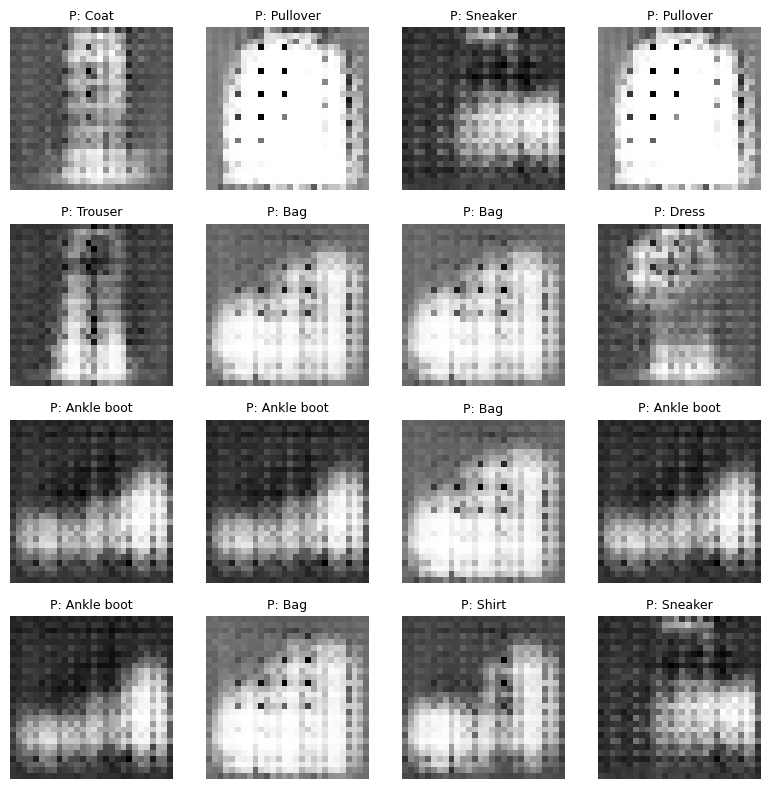

In [36]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import os

# -----------------------
# Device
# -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -----------------------
# Hyperparameters
# -----------------------
batch_size = 128
epochs_gan = 5
epochs_classifier = 5
noise_dim = 100
num_gen_images_per_class = 100
num_classes = 10
gan_output_dir = "gan_images_pipeline"
os.makedirs(gan_output_dir, exist_ok=True)

# -----------------------
# Dataset
# -----------------------
transform = transforms.ToTensor()

class TensorFashionMNIST(datasets.FashionMNIST):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        return img, torch.tensor(target, dtype=torch.long)

train_dataset = TensorFashionMNIST(root="data", train=True, download=True, transform=transform)
test_dataset = TensorFashionMNIST(root="data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
           "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# -----------------------
# Conditional GAN
# -----------------------
class Generator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(noise_dim+num_classes,256*7*7),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1,(256,7,7)),
            nn.ConvTranspose2d(256,128,5,1,2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128,64,5,2,2,output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64,1,5,2,2,output_padding=1),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise,c],dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 5, 2, 2),  # 1 image channel + 1 label channel
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, 2, 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)
        )

    def forward(self,img,labels):
        # Convert labels to single-channel map
        label_map = labels.float().unsqueeze(1).unsqueeze(2).unsqueeze(3)
        label_map = label_map.expand(-1,1,img.size(2), img.size(3)) / (self.num_classes-1)
        x = torch.cat([img, label_map], dim=1)
        return self.model(x)

# Initialize GAN
generator = Generator(noise_dim=noise_dim,num_classes=num_classes).to(device)
discriminator = Discriminator(num_classes=num_classes).to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
adversarial_loss = nn.BCEWithLogitsLoss()

# -----------------------
# Train GAN
# -----------------------
print("=== Training Conditional GAN ===")
for epoch in range(epochs_gan):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size_curr = real_imgs.size(0)
        valid = torch.ones(batch_size_curr,1,device=device)
        fake = torch.zeros(batch_size_curr,1,device=device)

        # Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr,noise_dim,device=device)
        random_labels = torch.randint(0,num_classes,(batch_size_curr,),device=device)
        gen_imgs = generator(z, random_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, random_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), random_labels), fake)
        d_loss = (real_loss + fake_loss)/2
        d_loss.backward()
        optimizer_D.step()
    print(f"[cGAN] Epoch {epoch+1}/{epochs_gan} | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

# -----------------------
# Generate labeled GAN images
# -----------------------
generator.eval()
all_images, all_labels = [], []
with torch.no_grad():
    for label in range(num_classes):
        z = torch.randn(num_gen_images_per_class, noise_dim, device=device)
        labels = torch.full((num_gen_images_per_class,), label, dtype=torch.long, device=device)
        gen_imgs = generator(z, labels)
        gen_imgs = (gen_imgs + 1)/2  # scale to [0,1]
        all_images.append(gen_imgs.cpu())
        all_labels.append(labels.cpu())

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)
torch.save((all_images, all_labels), os.path.join(gan_output_dir,"gan_images_labeled.pt"))
print(f"✅ Generated conditional GAN images saved at {gan_output_dir}/gan_images_labeled.pt")

# -----------------------
# Classifier
# -----------------------
print("=== Training Classifier ===")
classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,512),
    nn.ReLU(),
    nn.Linear(512,512),
    nn.ReLU(),
    nn.Linear(512,num_classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

# Load GAN dataset
gan_images, gan_labels = torch.load(os.path.join(gan_output_dir,"gan_images_labeled.pt"))
gan_dataset = TensorDataset(gan_images, gan_labels)
augmented_dataset = ConcatDataset([train_dataset, gan_dataset])
augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

# Train classifier
for epoch in range(epochs_classifier):
    classifier.train()
    for X,y in augmented_loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = classifier(X)
        loss = loss_fn(logits,y)
        loss.backward()
        optimizer.step()

    # Evaluate
    classifier.eval()
    correct,total = 0,0
    with torch.no_grad():
        for X_test, y_test in DataLoader(test_dataset, batch_size=batch_size):
            X_test, y_test = X_test.to(device), y_test.to(device)
            preds = classifier(X_test).argmax(dim=1)
            correct += (preds==y_test).sum().item()
            total += y_test.size(0)
    print(f"[Classifier] Epoch {epoch+1}/{epochs_classifier} | Test Accuracy: {100*correct/total:.2f}%")

# -----------------------
# Visualize predictions on GAN images
# -----------------------
classifier.eval()
plt.figure(figsize=(8,8))
num_samples = 16
indices = random.sample(range(len(gan_dataset)), num_samples)
for i, idx in enumerate(indices):
    x = gan_dataset[idx][0].unsqueeze(0).to(device)
    with torch.no_grad():
        pred = classifier(x).argmax(dim=1).item()
    plt.subplot(4,4,i+1)
    plt.imshow(gan_dataset[idx][0][0], cmap="gray")
    plt.title(f"P: {classes[pred]}", fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()


Using device: cuda
=== Training Conditional GAN ===
[cGAN] Epoch 1/5 | D loss: 0.0080 | G loss: 4.8642
[cGAN] Epoch 2/5 | D loss: 0.0434 | G loss: 3.9500
[cGAN] Epoch 3/5 | D loss: 0.2856 | G loss: 1.7474
[cGAN] Epoch 4/5 | D loss: 0.6696 | G loss: 0.8921
[cGAN] Epoch 5/5 | D loss: 0.5162 | G loss: 1.1917
✅ Generated conditional GAN images saved at gan_images_pipeline/gan_images_labeled.pt
=== Training Classifier ===
[Classifier] Epoch 1/5 | Test Accuracy: 82.94%
[Classifier] Epoch 2/5 | Test Accuracy: 85.93%
[Classifier] Epoch 3/5 | Test Accuracy: 86.97%
[Classifier] Epoch 4/5 | Test Accuracy: 87.52%
[Classifier] Epoch 5/5 | Test Accuracy: 87.19%


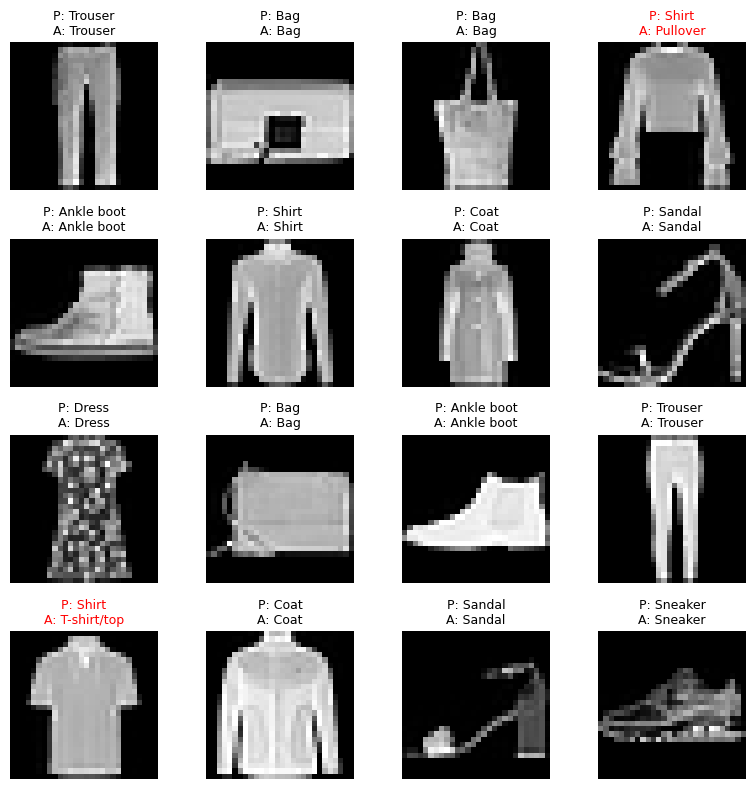

In [37]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import os

# -----------------------
# Device
# -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -----------------------
# Hyperparameters
# -----------------------
batch_size = 128
epochs_gan = 5
epochs_classifier = 5
noise_dim = 100
num_gen_images_per_class = 100
num_classes = 10
gan_output_dir = "gan_images_pipeline"
os.makedirs(gan_output_dir, exist_ok=True)

# -----------------------
# Dataset
# -----------------------
transform = transforms.ToTensor()

class TensorFashionMNIST(datasets.FashionMNIST):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        return img, torch.tensor(target, dtype=torch.long)

train_dataset = TensorFashionMNIST(root="data", train=True, download=True, transform=transform)
test_dataset = TensorFashionMNIST(root="data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
           "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# -----------------------
# Conditional GAN
# -----------------------
class Generator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(noise_dim+num_classes,256*7*7),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1,(256,7,7)),
            nn.ConvTranspose2d(256,128,5,1,2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128,64,5,2,2,output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64,1,5,2,2,output_padding=1),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise,c],dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 5, 2, 2),  # 1 image channel + 1 label channel
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, 2, 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)
        )

    def forward(self,img,labels):
        label_map = labels.float().unsqueeze(1).unsqueeze(2).unsqueeze(3)
        label_map = label_map.expand(-1,1,img.size(2), img.size(3)) / (self.num_classes-1)
        x = torch.cat([img, label_map], dim=1)
        return self.model(x)

# -----------------------
# Initialize GAN
# -----------------------
generator = Generator(noise_dim=noise_dim,num_classes=num_classes).to(device)
discriminator = Discriminator(num_classes=num_classes).to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
adversarial_loss = nn.BCEWithLogitsLoss()

# -----------------------
# Train Conditional GAN
# -----------------------
print("=== Training Conditional GAN ===")
for epoch in range(epochs_gan):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size_curr = real_imgs.size(0)
        valid = torch.ones(batch_size_curr,1,device=device)
        fake = torch.zeros(batch_size_curr,1,device=device)

        # Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr,noise_dim,device=device)
        random_labels = torch.randint(0,num_classes,(batch_size_curr,),device=device)
        gen_imgs = generator(z, random_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, random_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), random_labels), fake)
        d_loss = (real_loss + fake_loss)/2
        d_loss.backward()
        optimizer_D.step()
    print(f"[cGAN] Epoch {epoch+1}/{epochs_gan} | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

# -----------------------
# Generate labeled GAN images for augmentation
# -----------------------
generator.eval()
all_images, all_labels = [], []
with torch.no_grad():
    for label in range(num_classes):
        z = torch.randn(num_gen_images_per_class, noise_dim, device=device)
        labels_tensor = torch.full((num_gen_images_per_class,), label, dtype=torch.long, device=device)
        gen_imgs = generator(z, labels_tensor)
        gen_imgs = (gen_imgs + 1)/2  # scale to [0,1]
        all_images.append(gen_imgs.cpu())
        all_labels.append(labels_tensor.cpu())

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)
torch.save((all_images, all_labels), os.path.join(gan_output_dir,"gan_images_labeled.pt"))
print(f"✅ Generated conditional GAN images saved at {gan_output_dir}/gan_images_labeled.pt")

# -----------------------
# Train Classifier on real + GAN images
# -----------------------
print("=== Training Classifier ===")
classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,512),
    nn.ReLU(),
    nn.Linear(512,512),
    nn.ReLU(),
    nn.Linear(512,num_classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

gan_images, gan_labels = torch.load(os.path.join(gan_output_dir,"gan_images_labeled.pt"))
gan_dataset = TensorDataset(gan_images, gan_labels)
augmented_dataset = ConcatDataset([train_dataset, gan_dataset])
augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs_classifier):
    classifier.train()
    for X,y in augmented_loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = classifier(X)
        loss = loss_fn(logits,y)
        loss.backward()
        optimizer.step()

    # Evaluate on real test images
    classifier.eval()
    correct,total = 0,0
    with torch.no_grad():
        for X_test, y_test in DataLoader(test_dataset, batch_size=batch_size):
            X_test, y_test = X_test.to(device), y_test.to(device)
            preds = classifier(X_test).argmax(dim=1)
            correct += (preds==y_test).sum().item()
            total += y_test.size(0)
    print(f"[Classifier] Epoch {epoch+1}/{epochs_classifier} | Test Accuracy: {100*correct/total:.2f}%")

# -----------------------
# Visualize predictions on real Fashion-MNIST test images
# -----------------------
classifier.eval()
plt.figure(figsize=(8,8))
num_samples = 16
indices = random.sample(range(len(test_dataset)), num_samples)

for i, idx in enumerate(indices):
    x, y_actual = test_dataset[idx]
    x_device = x.unsqueeze(0).to(device)
    with torch.no_grad():
        y_pred_idx = classifier(x_device).argmax(dim=1).item()
        y_pred = classes[y_pred_idx]
        y_actual_label = classes[y_actual]

    plt.subplot(4, 4, i+1)
    plt.imshow(x.squeeze(), cmap="gray")
    color = "red" if y_pred != y_actual_label else "black"
    plt.title(f"P: {y_pred}\nA: {y_actual_label}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()
